Chapter 13: Loading and Preprocessing Data with TensorFlow

Chapter 13 exercises:

1. Why would you want to use tf.data API?

-> The 'tf.data' API is TensorFlow's own data loading and preprocessing API. It is a powerful API for ingesting and preprocessing large datasets. It supports loading and preprocessing text files, binary files, TFRrecords, etc. It also supports reading multiple files in parallel using multithreading, queuing, shuffling, batching, interleaving, and prefectching.  


page 441: tf.data
 - TensorFlow's own data loading and preprocessing API
 - reads from multiple files in parallel using multithreading and queuing, shuffling and batching samples, ...
 - let's you handle datasets that don't fit in memory
 - can read text files (e.g. CSV), binary files with fixed record sizes, and binary files that use TensorFlow's TFRecord format which supports varying record sizes
 - supports reading from SQL databases and open source extensions to from all sorts of data sources

page 442 - 443: tf.data.Dataset 
 - 'tf.data' API revolves around the concept of a 'tf.data.Dataset'
 - represents a sequence of data items
 - datasets may contain tuples of tensors, or dictionary of name/tensor pairs, or even nested tuples and dictionary of tensors
 - When slicing a tuple, dictionary, or a nested structure, the dataset will only slice the tensors it contains while preserving the tuple/dictionarly structure

https://www.tensorflow.org/guide/data: Basic Mechanics
 - To create an input pipeline, you must start with a data source. 
 - For example, to construct a Dataset from data in memory, you can use tf.data.Dataset.from_tensors() or tf.data.Dataset.from_tensor_slices(). 
 - Alternatively, if your input data is stored in a file in the recommended TFRecord format, you can use: tf.data.TFRecordDataset().


__book answer__: Ingesting a large dataset and preprocessing it efficiently can be a complex engineering challenge. The Data API makes it fairly simple. It offers many features, including loading data from various sources (such as text or binary files), reading data in parallel from multiple sources, transforming it, interleaving the records, shuffling the data, batching it, and prefetching it.

2. What are the benefits of splitting a large dataset into multiple files?

-> It allows you to load and shuffle very large datasets. By splitting the dataset into multiple files, you can load and shuffle datasets in parallel using multi-thread loading of the multiple files which can expedite the loading and preprocessing of the dataset. With multiple files, can interleave and shuffle the data between files and then futher shuffle the data as it is being preprocessed.

page 446: Shuffle data by using multiple randomly filed files:
 - to handle the shuffle() large dataset limitation, split the source data into multiple files, and then randomly and read them simultaneously, interleaving their records
 - then on top, you can add a shuffling buffer using the shuffle() method

13_loading_and_preprocessing_data.ipynb - section 2.2.1:
For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and saving it to 20 CSV files:


__book answer__: Splitting a large dataset into multiple files makes it possible to shuffle it at a coarse level before shuffling it at a finer level using a shuffling buffer. It also makes it possible to handle huge datasets that do not fit on a single machine. It's also simpler to manipulate thousands of small files rather than one huge file; for example, it's easier to split the data into multiple subsets. Lastly, if the data is split across multiple files spread across multiple servers, it is possible to download several files from different servers simultaneously, which improves the bandwidth usage.

3. During training, how can you tell that your input pipeline is the bottleneck? What can you do to fix it?

-> You can use TensorBoard to visualize profiling data: if the GPU is not fully utilized then your input pipeline is likely to be the bottleneck. You can fix it by making sure it reads and preprocesses the data in multiple threads in parallel, and ensuring it prefetches a few batches.

page 340:TensorBoard
 - interactive visualization tool
 - can view the learning curves during training, compare curves and metrics between multiple runs visualize the computation graphs, analyze training statistics, view images generated by your model, visualize complex multidimensional data projected down to 3D, profile your network (measure its speed to identify bottlenecks)


page 450:
By calling 'prefetch(1)' at the end of the 'csv_reader_dataset()' function, we are creating a dataset that will do its best to always be batch ahead. In other words, while our training algorithm is working on one batch, the datas will already be working in parallel on getting  the next batch ready (e.g. reading the data from disk and preprocesing it). This can improve preformance dramatically, as is illustrated in Figure 13-3.

page 450:
If we also ensure that loading and preprocessing are multithreaded (by setting 'num_parallel_calls' when calling 'interleave()' and 'map()'), we can exploit multipe CPU cores and hopefully make preparing one batch of data shorter than running a training step on the GPU: this way the GPU will be 100% utilized (except for the data transfer time from the CPU to the GPU), and train will run much faster.  

page 451:
If the dataset is small enough to fit in memory, you can significantly speed up training by using the dataset's 'cache()' method to cache its content to RAM. You should generally do this after loading and preprocessing the data, bu before shuffling, repeating, batching. and prefetching. This way, each instance will only be read and preprocessed once (instead of once each epoch), but the data will still be shuffled differently at each epoch, and the next batch will still be prepared in advanced.


__book answer__: You can use TensorBoard to visualize profiling data: if the GPU is not fully utilized then your input pipeline is likely to be the bottleneck. You can fix it by making sure it reads and preprocesses the data in multiple threads in parallel, and ensuring it prefetches a few batches. If this is insufficient to get your GPU to 100% usage during training, make sure your preprocessing code is optimized. You can also try saving the dataset into multiple TFRecord files, and if necessary perform some of the preprocessing ahead of time so that it does not need to be done on the fly during training (TF Transform can help with this). If necessary, use a machine with more CPU and RAM, and ensure that the GPU bandwidth is large enough.

4. Can you save any binary data to a TFRecord file, or only serialized protocol buffers?

-> A TFRecord contains a sequence of binary records of varying sizes. Each record is comprised of a length, a length CRC checksum, then the actual data, and the CRC checksum for the data. Yes, You can save any binary data you want.

-> In practice most TFRecord files contain sequences of serialized protocol buffers. This makes it possible to benefit from the advantages of protocol buffers, such as the fact that they can be read easily across multiple platforms and languages and their definition can be updated later in a backward-compatible way.

page 453:  TFRecord Format:
 - TensorFlow's preferred format for storing large amount of data and reading it efficiently
 - simple binary format that contains a sequence of binary records of varying sizes
 - each record is comprised of a length, a length CRC checksum, then the actual data, and the CRC checksum for the data
 - You can create a TFRecord using a tf.io.TFRecordWriter
 - you can read a TFRecord using a tf.data.TFRecordDataset

https://www.tensorflow.org/tutorials/load_data/tfrecord:
The TFRecord format is a simple format for storing a sequence of binary records. Protocol buffers are a cross-platform, cross-language library for efficient serialization of structured data. Protocol messages are defined by . proto files, these are often the easiest way to understand a message type.

__book answer__:  A TFRecord file is composed of a sequence of arbitrary binary records: you can store absolutely any binary data you want in each record. However, in practice most TFRecord files contain sequences of serialized protocol buffers. This makes it possible to benefit from the advantages of protocol buffers, such as the fact that they can be read easily across multiple platforms and languages and their definition can be updated later in a backward-compatible way.

5. Why would go through the hassle of converting all your data to the Example protobuf format? Why not use your own protobuf definition?

->  The `Example` protobuf format has the advantage that TensorFlow provides some operations to parse it (the `tf.io.parse`*`example()` functions) without you having to define your own format. It is sufficiently flexible to represent instances in most datasets

->  It's more complicated, and it requires deploying the descriptor along with the model, but it can be done.

page 454:
protocol buffers (protbufs)
 Overview
  - even though each record can use any binary format you want, TFRecord files usually containn serialized 'protocol buffers' (also called 'protobufs).
  - protobufs is a portable, extensible, and efficient binary format developed by Google
  - protobufs are widely used, in particular in gRPC (https://grpc.io)
Protobuf example definition:
 - below protobuff example definition:
   - use version 3 of the protobuff format ("proto3")
   - each "Person" object may optionally have a name of type string, and id of type int32, and 0 or more email fields, each of type string
   - the numbers 1, 2, and 3 are the field identifiers
compiling protobuff definition
  - once you have a protobuff definition in a '.proto' file, you can compile it using 'protoc'
  - this requires 'protoc' the protobuf compiler to generate access classes in python (or other language) 
protobuff definitions
  - you will generally use in TensorFlow have already been compiled for you, and their classes are part of the TensorFlow library

__book answer__: The `Example` protobuf format has the advantage that TensorFlow provides some operations to parse it (the `tf.io.parse`*`example()` functions) without you having to define your own format. It is sufficiently flexible to represent instances in most datasets. However, if it does not cover your use case, you can define your own protocol buffer, compile it using `protoc` (setting the `--descriptor_set_out` and `--include_imports` arguments to export the protobuf descriptor), and use the `tf.io.decode_proto()` function to parse the serialized protobufs (see the "Custom protobuf" section of the notebook for an example). It's more complicated, and it requires deploying the descriptor along with the model, but it can be done.

6. When using TFRecords, when would you want to activate compression? Why not do it systematically?

-> If you are loading records via a network connection activate compression can reduce the download time. Compression will also reduce the file sizes. If not using a network connection, it may be preferable to not compress the files.

page 454: Compressed TFRecords
 - it can sometimes be useful to compress your TFRecords, especially if they need to be loaded via network connection
 - create compressed TFRecord file by setting the tf.io.TFRecordOptions(compression_type="<compressionType>")
 - read compressed TFRecord file(s) by setting the 'tf.data.TFRecordDataset' "compression_type" argument 

__book answer__: When using TFRecords, you will generally want to activate compression if the TFRecord files will need to be downloaded by the training script, as compression will make files smaller and thus reduce download time. But if the files are located on the same machine as the training script, it's usually preferable to leave compression off, to avoid wasting CPU for decompression.

7. Data can be preprocessed directly when writing the data files, or within the tf.data pipeline, or in preprocessing layers with your model. Can list a few pros and cons of each option?

-> preprocessing directly when writing the data files pros and cons: The train scripts will run faster and the preprocessed data may be smaller. However, you will not be able to reuse preprocessing flow for production, not easy to experiment with preprocessing logic, etc.

-> preprocessing within the tf.data pipeline: it's much easier to tweak the preprocessing logic and apply data augmentation. Also, tf.data makes it easy to build highly efficient preprocessing pipelines (e.g., with multithreading and prefetching). However, preprocessing the data this way will slow down training.

-> preprocessing layers with your model:  you will only have to write the preprocessing code once for both training and inference. If your model needs to be deployed to many different platforms, you will not need to write the preprocessing code multiple times. Plus, you will not run the risk of using the wrong preprocessing logic for your model, since it will be part of the model. On the downside, preprocessing the data on the fly during training will slow things down, and each instance will be preprocessed once per epoch.

pages 459 - 460: Preprocessing options
 preprocessing ahead of time
   - using any tools you like, such as Numpy, Pandas, or Scikit-learn
 preprocessing on the fly using dataset's map method
   - preprocessing all input data on the fly using 'map()' method while loading it with 'tf.data()'
 preprocessing layers in your model
   - adding preprocessing mayers directly inside your model so it can preprocess all input data on the fly during training


__book answer__: Let's look at the pros and cons of each preprocessing option:
    * If you preprocess the data when creating the data files, the training script will run faster, since it will not have to perform preprocessing on the fly. In some cases, the preprocessed data will also be much smaller than the original data, so you can save some space and speed up downloads. It may also be helpful to materialize the preprocessed data, for example to inspect it or archive it. However, this approach has a few cons. First, it's not easy to experiment with various preprocessing logics if you need to generate a preprocessed dataset for each variant. Second, if you want to perform data augmentation, you have to materialize many variants of your dataset, which will use a large amount of disk space and take a lot of time to generate. Lastly, the trained model will expect preprocessed data, so you will have to add preprocessing code in your application before it calls the model. There's a risk of code duplication and preprocessing mismatch in this case.
    * If the data is preprocessed with the tf.data pipeline, it's much easier to tweak the preprocessing logic and apply data augmentation. Also, tf.data makes it easy to build highly efficient preprocessing pipelines (e.g., with multithreading and prefetching). However, preprocessing the data this way will slow down training. Moreover, each training instance will be preprocessed once per epoch rather than just once if the data was preprocessed when creating the data files. Well, unless the dataset fits in RAM and you can cache it using the dataset's `cache()` method. Lastly, the trained model will still expect preprocessed data. But if you use preprocessing layers in your tf.data pipeline to handle the preprocessing step, then you can just reuse these layers in your final model (adding them after training), to avoid code duplication and preprocessing mismatch.
    * If you add preprocessing layers to your model, you will only have to write the preprocessing code once for both training and inference. If your model needs to be deployed to many different platforms, you will not need to write the preprocessing code multiple times. Plus, you will not run the risk of using the wrong preprocessing logic for your model, since it will be part of the model. On the downside, preprocessing the data on the fly during training will slow things down, and each instance will be preprocessed once per epoch.

8. Name a few common ways you can encode categorical integer features. What about text?

-> To encode a categorical feature that has a natural order, such as a movie rating (e.g., "bad," "average," "good"), the simplest option is to use ordinal encoding: sort the categories in their natural order and map each category to its rank (e.g., "bad" maps to 0, "average" maps to 1, and "good" maps to 2).

-> However, most categorical features don't have such a natural order. For example, there's no natural order for professions or countries. In this case, you can use one-hot encoding, or embeddings if there are many categories. With Keras, the `StringLookup` layer can be used for ordinal encoding (using the default `output_mode="int"`), or one-hot encoding (using `output_mode="one_hot"`). It can also perform multi-hot encoding (using `output_mode="multi_hot"`) if you want to encode multiple categorical text features together, assuming they share the same categories and it doesn't matter which feature contributed which category. For trainable embeddings, you must first use the `StringLookup` layer to produce an ordinal encoding, then use the `Embedding` layer.

-> For text, the `TextVectorization` layer is easy to use and it can work well for simple tasks, or you can use TF Text for more advanced features. However, you'll often want to use pretrained language models, which you can obtain using tools like TF Hub or Hugging Face's Transformers library. These last two options are discussed in Chapter 16.


page 465: 
StringLookup layer
 - used to convert categorical text features to encode as integers (default) or one-hot encodes
 - uses 'adapt()' method to find the distinct categories 
 - use 'output_mode="one_hot" to encode with one-hot vector for each category instead of an integers (default)
 - known categories are numbered starting at '1', from the most frequent category to the least frequent
 - Unknown categories by default (categories not present list passed to 'adapt()') are mapped to category '0'
 - Instead of mapping unknown categories to '0', you can specify the number Out-of-vocabulary (OOV) buckets to use, with the num_oov_indices argument. Each unknown category will get mapped psuedorandomly to one of the OOV buckets allowing the model to distinguish at least some of the rare categories
   - OUV buckets numbers are from 0 to num_oov_indices (if num_oov_indices=5, then from 0 to 4)
 - hashing collisions: when multiple unknown categories get mapped to the same OOV due to insufficient OOV buckets
 StringLookup.adapt() method
  - Computes a vocabulary of integer terms from tokens in a dataset.
 StringLookup.vocabulary_size() method
  - returns The integer size of the vocabulary, including optional mask and oov indices. 
  - by default, vocabulary size includes 'category 0' for mapping unknown categories
  - total number of categories including known categories plus OOV buckets (one by default)

page 466:
Embedding [Categorical Features]
  - a dense representation of some higher-dimensional data, such as a category, or a word in a vocabulary
  - a 50k categories with one-hot encoding would produce 50k-dimensional sparse vectory. In contrast, an embedding would be comparably smale dense vector with ~100 dimensions
  - in deep learning, embedded are usually initialized randonly, and then they are trained with gradient descent, along with other model parameters
  - since embedding are trainable, they will gradually improve during training.
  - training tends to make enbeddings useful representations of the categories - this is called representation learning
  representation learning
    - is a process in machine learning where algorithms extract meaningful patterns from raw data to create representations that are easier to understand and process. 
  word embedding 
    - embeddings of individual words
    - word embeddings of similar words tend to be close, and some axes seem to encode meaningful concepts (Figure 13-7)
  embedding reuse
    - embeddings generally be useful representations fo the task at hand, but quite often these same embeddings can be reused successfully for other tasks
    - most common example of embedding reuse is word embedding
  - embeddings typically have 10 to 300 dimensions (not 2D as used in example), depending on the task, the vocabulary size, and the size of your training set

pages 471 - 472
TextVectorization Layer
  - for basic text preprocessing
  - must either pass it a vocabulary upon creation, or let it learn the vocabuarly from some training data using its 'adapt()' method
  - when encoding sentences, unknown words are encoded as '1's, and shorter sentences are padded with zeros
  TextVectorization.adapt() method
    - first, by default, converts training sentences to lowercase and removes punctuation
    - next, the sentences are split on whitespaces, and resulting words are sorted by frequency, producing the final vocabulary
  TextVectorization arguments include:
    standardize=
      None:  preserves case and punctuation (no standardization)
      <std_fcn>:  passes standardization function, <std_fcn>
    split=
      lower_and_strip_punctuation (default): Text will be lowercased and all punctuation removed.
      None: prevents splitting
    <splitting_fcn>: passes splitting function, <splitting_fcn>
    output_sequence_length=<output_sequence_length>
      - used to ensure all output sequences all get cropped or padded to the desired length
    ragged=
      True: get a ragged tensor rather than a regular tensor
    output_mode=
      int (default): Outputs integer indices, one integer index per split string token. When output_mode == "int", 0 is reserved for masked locations; this reduces the vocab size to max_tokens - 2 instead of max_tokens - 1.
      multi_hot: Outputs a single int array per batch, of either vocab_size or max_tokens size, containing 1s in all elements where the token mapped to that index exists at least once in the batch item.
      count:  Like "multi_hot", but the int array contains a count of the number of times the token at that index appeared in the batch item.  
      tf_idf: term-frequency x inverse-document-frequency (TF-IDF): This is similar to the count encoding, but words that occur frequently in the training data are downweighted, and conversely, rare words are upweighted 

__book answer__: Let's look at how to encode categorical text features and text:

    * To encode a categorical feature that has a natural order, such as a movie rating (e.g., "bad," "average," "good"), the simplest option is to use ordinal encoding: sort the categories in their natural order and map each category to its rank (e.g., "bad" maps to 0, "average" maps to 1, and "good" maps to 2). However, most categorical features don't have such a natural order. For example, there's no natural order for professions or countries. In this case, you can use one-hot encoding, or embeddings if there are many categories. With Keras, the `StringLookup` layer can be used for ordinal encoding (using the default `output_mode="int"`), or one-hot encoding (using `output_mode="one_hot"`). It can also perform multi-hot encoding (using `output_mode="multi_hot"`) if you want to encode multiple categorical text features together, assuming they share the same categories and it doesn't matter which feature contributed which category. For trainable embeddings, you must first use the `StringLookup` layer to produce an ordinal encoding, then use the `Embedding` layer.
    
    * For text, the `TextVectorization` layer is easy to use and it can work well for simple tasks, or you can use TF Text for more advanced features. However, you'll often want to use pretrained language models, which you can obtain using tools like TF Hub or Hugging Face's Transformers library. These last two options are discussed in Chapter 16.

In [23]:
import numpy as np
import sklearn
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [26]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 9. 
Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized Example protobuf with twe features; the serialized image (use tf.io.serialize_tensor() to serialize the image), and the label. Then use tf.data to create an efficient dataset for each set. Finally, use Keras model to train these datasets, including a preprocessing layer to standardized each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.

### 9 a.
Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized Example protobuf with twe features; the serialized image (use tf.io.serialize_tensor() to serialize the image), and the label.

In [1]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [2]:
tf.random.set_seed(42)
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(len(X_train), seed=42)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [7]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

In [8]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))

In [9]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\002\000\000\000\000\000\000\000\000\000\000\000\000\000\000\002\000\000\000\000\000\000\000\000\000\000\000\000\000\000\030\254\247bXT^j\224\272J\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000m\335\347\360\356\357\360\341\346\360\356\357\356\322\253\036\000\000\000\000\000\000\000\000\000\000\000\267\364\340\325\325\327\325\324\325\324\323\322\326\325\333\351\351q\000\000\000\000\000\000\000\000\000\262\366\333\321\325\324\325\327\325\325\325\323\327\327\317\325\324\341\330\000\000\000\000\000\000\000\000\000\'\344\334\317\321\321\322\323\321\320\320\324\321\320\315\325\325\355v\000\000\000\000\000\000\000\000\000\t\333\333\325\321\325\323\324\321\320\321\322\323\321\313\331\327\346\212\000\000\000\000\000\000\000\000\000\033\330\322\320\317\320\324\320\317\316\317\317\324\325\315\336\336\342\225\000\0

The following function saves a given dataset to a set of TFRecord files. The examples are written to the files in a round-robin fashion. To do this, we enumerate all the examples using the `dataset.enumerate()` method, and we compute `index % n_shards` to decide which file to write to. We use the standard `contextlib.ExitStack` class to make sure that all writers are properly closed whether or not an I/O error occurs while writing.

In [11]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards) for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [16]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

### 9 b.
_Exercise: Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data._

In [17]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    #image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [18]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

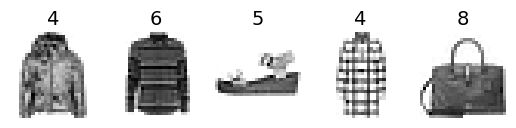

In [21]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

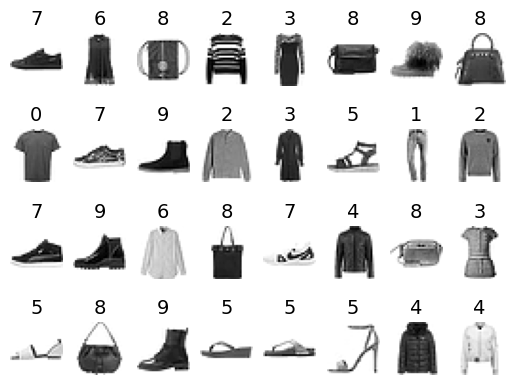

In [31]:
n_rows = 4
n_cols = 8
for X, y in train_set.take(1):
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(X[index].numpy(), cmap="binary")
            plt.axis("off")
            plt.title(str(y[index].numpy()))

In [32]:
tf.random.set_seed(42)

standardization = tf.keras.layers.Normalization(input_shape=[28, 28])

# train_set dataset contains image & label, just return the image
sample_image_batches = train_set.take(100).map(lambda image, label: image)
# return a list of the images converted to float32 values
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()), axis=0).astype(np.float32)
# standardized images values
standardization.adapt(sample_images)

model = tf.keras.Sequential([
    standardization,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

C:\Users\pat\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
from datetime import datetime

logs = Path() / "my_logs" / "run_" / datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, profile_batch=10)

# train model and include tensorBoard callbacks
model.fit(train_set, epochs=5, validation_data=valid_set, callbacks=[tensorboard_cb])

Epoch 1/5
   1704/Unknown 7s 3ms/step - accuracy: 0.8059 - loss: 0.5508

C:\Users\pat\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8062 - loss: 0.5499 - val_accuracy: 0.8600 - val_loss: 0.3701
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8757 - loss: 0.3458 - val_accuracy: 0.8720 - val_loss: 0.3554
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8917 - loss: 0.2960 - val_accuracy: 0.8846 - val_loss: 0.3271
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9009 - loss: 0.2709 - val_accuracy: 0.8816 - val_loss: 0.3265
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9077 - loss: 0.2471 - val_accuracy: 0.8830 - val_loss: 0.3397


In [34]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

In [35]:
# close tensorboard
!taskkill /IM "tensorboard.exe" /F
!rmdir /S /Q %temp%\.tensorboard-info

SUCCESS: The process "tensorboard.exe" with PID 23384 has been terminated.


### 10. 
In this exercise you will download a dataset, split it, create a 'tf.data.Dataset' to load it and preprocess it efficiently, then build and train a binary classification model containing an 'Embedding' layer.

### 10 a. 
Download the Large Movie Review Dataset (https://homl.info/imdb) which contains 50,000 movie reviews from the Internet Movie Database (IMDb) (https://imdb.com). The data is organized in two directories, train and test, each containing a 'pos' subdirectory with 12,500 positive reviews and a 'neg' subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words versions), but we will ignore them in this exercise.

In [36]:
from pathlib import Path

root = "https://ai.stanford.edu/~amaas/data/sentiment/"
filename = "aclImdb_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename, root + filename, extract=True,
                                   cache_dir=".")
path = Path(filepath).with_name("aclImdb")
path

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


WindowsPath('datasets/aclImdb')

In [37]:
def tree(path, level=0, indent=4, max_files=3):
    if level == 0:
        print(f"{path}/")
        level += 1
    sub_paths = sorted(path.iterdir())
    sub_dirs = [sub_path for sub_path in sub_paths if sub_path.is_dir()]
    filepaths = [sub_path for sub_path in sub_paths if not sub_path in sub_dirs]
    indent_str = " " * indent * level
    for sub_dir in sub_dirs:
        print(f"{indent_str}{sub_dir.name}/")
        tree(sub_dir,  level + 1, indent)
    for filepath in filepaths[:max_files]:
        print(f"{indent_str}{filepath.name}")
    if len(filepaths) > max_files:
        print(f"{indent_str}...")

In [38]:
tree(path)

datasets\aclImdb/
    test/
        neg/
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos/
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
    train/
        neg/
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos/
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup/
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
    imdb.vocab
    imdbEr.txt
    README


In [39]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

### 10 b.
Split the test set into a validation set (15,000) and a test set (10,000).

In [40]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

### 10 c.
Use 'tf.data' to create an efficient dataset for each set.

Since the dataset fits in memory, we can just load all the data using pure Python code and use `tf.data.Dataset.from_tensor_slices()`:

In [41]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [64]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

tf.Tensor(b"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)

tf.Tensor(b"Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public a

In [57]:
def imdb_dataset_tst(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    cnt = 0
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            try:
                with open(filepath) as review_file:
                    reviews.append(review_file.read())
                labels.append(label)
            except:
                print(f'ERROR: filepath({cnt}): {filepath}')
            cnt += 1
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [82]:
for X, y in imdb_dataset_tst(test_pos, test_neg).take(1):
    print(X)
    print(y)
    print()

tf.Tensor(b"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)



In [84]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

50.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [85]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000, seed=42)
train_set = train_set.batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

10 d. Createa a binary classification model, using a 'TextVectorization' layer to preprocess reviews.

Let's create a `TextVectorization` layer and adapt it to the full IMDB training set (if the training set did not fit in RAM, we could just use a smaller sample of the training set by calling `train_set.take(500)`). Let's use TF-IDF for now.

Note: TextVectoriziation max_tokens argument: Maximum size of the vocabulary for this layer. ....

In [86]:
max_tokens = 1000
sample_reviews = train_set.map(lambda review, label: review)
text_vectorization = tf.keras.layers.TextVectorization(max_tokens=max_tokens, output_mode="tf_idf")
text_vectorization.adapt(sample_reviews)

Good! Now let's take a look at the first 10 words in the vocabulary:

In [87]:
text_vectorization.get_vocabulary()[:10]

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']

These are the most common words in the reviews.

We're ready to train the model!

In [88]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7890 - loss: 0.4743 - val_accuracy: 0.8466 - val_loss: 0.3760
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8568 - loss: 0.3546 - val_accuracy: 0.8452 - val_loss: 0.3729
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8718 - loss: 0.3196 - val_accuracy: 0.8507 - val_loss: 0.3661
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8936 - loss: 0.2598 - val_accuracy: 0.8509 - val_loss: 0.3702
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9255 - loss: 0.1898 - val_accuracy: 0.8447 - val_loss: 0.3843


We get about 84.2% accuracy on the validation set after just the first epoch, but after that the model makes no significant progress. We will do better in Chapter 16. For now the point is just to perform efficient preprocessing using `tf.data` and Keras preprocessing layers.

10 e. Add a 'Embedding' layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can be passed to the rest of your model.

To compute the mean embedding for each review, and multiply it by the square root of the number of words in that review, we will need a little function. For each sentence, this function needs to compute $M \times \sqrt N$, where $M$ is the mean of all the word embeddings in the sentence (excluding padding tokens), and $N$ is the number of words in the sentence (also excluding padding tokens). We can rewrite $M$ as $\dfrac{S}{N}$, where $S$ is the sum of all word embeddings (it does not matter whether or not we include the padding tokens in this sum, since their representation is a zero vector). So the function must return $M \times \sqrt N = \dfrac{S}{N} \times \sqrt N = \dfrac{S}{\sqrt N \times \sqrt N} \times \sqrt N= \dfrac{S}{\sqrt N}$.

In [89]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

Let's check that this is correct. The first review contains 2 words (the last token is a zero vector, which represents the `<pad>` token). Let's compute the mean embedding for these 2 words, and multiply the result by the square root of 2:

In [93]:
tf.reduce_mean(another_example[0:1, :2], axis=1) * tf.sqrt(2.)

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[3, 2, 0],
       [1, 0, 0]], dtype=int64)>

Looks good! Now let's check the second review, which contains just one word (we ignore the two padding tokens):

In [104]:
tf.reduce_mean(another_example[1:2, :1], axis=1) * tf.sqrt(1.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6., 0., 0.]], dtype=float32)>

Perfect. Now we're ready to train our final model. It's the same as before, except we replaced TF-IDF with ordinal encoding (`output_mode="int"`) followed by an `Embedding` layer, followed by a `Lambda` layer that calls the `compute_mean_embedding` layer:

In [105]:
embedding_size = 20
tf.random.set_seed(42)

text_vectorization = tf.keras.layers.TextVectorization(max_tokens=max_tokens, output_mode="int")
text_vectorization.adapt(sample_reviews)

model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Embedding(input_dim=max_tokens,
                              output_dim=embedding_size,
                              mask_zero=True),  # <pad> tokens => zero vectors
    tf.keras.layers.Lambda(compute_mean_embedding),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

10 f. Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible. 

In [106]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5



C:\Users\pat\anaconda3\Lib\site-packages\keras\src\layers\layer.py:857: UserWarning: Layer 'lambda' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5755 - loss: 0.6701 - val_accuracy: 0.7077 - val_loss: 0.5539
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7345 - loss: 0.5415 - val_accuracy: 0.6071 - val_loss: 0.8595
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7826 - loss: 0.4690 - val_accuracy: 0.8001 - val_loss: 0.4294
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8053 - loss: 0.4215 - val_accuracy: 0.7229 - val_loss: 0.5250
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8116 - loss: 0.4164 - val_accuracy: 0.8075 - val_loss: 0.4034


The model is just marginally better using embeddings (but we will do better in Chapter 16). The pipeline looks fast enough (we optimized it earlier).

10 g. Use TFDS to load the same dataset more easily; tfds.load("imdb_reviews")

In [107]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\pat\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incomplete7MFIJ4\imdb_reviews-train.t…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\pat\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incomplete7MFIJ4\imdb_reviews-test.tf…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\pat\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incomplete7MFIJ4\imdb_reviews-unsuper…

Dataset imdb_reviews downloaded and prepared to C:\Users\pat\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [109]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
